# Louvain Clustering with Autoencoder Latent Space

This notebook implements patient clustering using:
1. **Autoencoder** to learn compressed latent representations of 44 biochemistry features
2. **Distance matrix** computed in the latent space
3. **Louvain clustering** on the KNN similarity graph
4. **t-SNE visualization** of clusters

**Pipeline**: Raw Data → Preprocessing → Autoencoder → Latent Space → Distance Matrix → KNN Graph → Louvain → Visualization


In [21]:
import pandas as pd
import numpy as np
import os
import warnings
warnings.filterwarnings('ignore')

# Sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Visualization
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

# Distance & Graph
from scipy.spatial.distance import cdist
import networkx as nx
from tqdm import tqdm

# Louvain
%pip install python-louvain ipywidgets -q
import community as community_louvain

# Configuration
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Base paths
DATA_PATH = "../../data"
DATA_DATES_PATH = os.path.join(DATA_PATH, "data_dates")
DATA_HESIN_PATH = os.path.join(DATA_PATH, "data_hesin")
DATA_UKB_PATH = os.path.join(DATA_PATH, "data_ukb")



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Using device: cpu


In [22]:
# Load all datasets
print("Loading datasets...")
date_blood_taken_df = pd.read_csv(os.path.join(DATA_DATES_PATH, "date_blood_taken_dates.csv"))
data_hesin_dates_df = pd.read_csv(os.path.join(DATA_HESIN_PATH, "data_hesin_dates_fixed.csv"))
biochemistry_df = pd.read_csv(os.path.join(DATA_UKB_PATH, "count_biochemistry_data.csv"))

print(f"Date Blood Taken: {date_blood_taken_df.shape}")
print(f"HESIN Dates: {data_hesin_dates_df.shape}")
print(f"Biochemistry: {biochemistry_df.shape}")


Loading datasets...
Date Blood Taken: (501936, 2)
HESIN Dates: (17495611, 4)
Biochemistry: (501936, 45)


In [23]:
# Define healthy population: blood_before_hospital patients
# Parse dates
date_blood_taken_df["blood_date"] = pd.to_datetime(
    date_blood_taken_df["Time blood sample collected | Instance 0 | Array 0"], errors='coerce'
)
data_hesin_dates_df["event_date_parsed"] = pd.to_datetime(
    data_hesin_dates_df["event_date"], errors='coerce'
)

# Get first hospital date per patient
first_hesin = data_hesin_dates_df.groupby("eid")["event_date_parsed"].min().reset_index()
first_hesin.columns = ["Participant ID", "first_hospital_date"]

# Find patients with blood sample before first hospital visit
valid_blood = date_blood_taken_df[date_blood_taken_df["blood_date"].notna()]
merged = valid_blood[["Participant ID", "blood_date"]].merge(first_hesin, on="Participant ID", how="inner")
blood_before_hospital = merged[merged["blood_date"] < merged["first_hospital_date"]]
target_patients = set(blood_before_hospital["Participant ID"].unique())

# Get biochemistry data for these patients
healthy_df = biochemistry_df[biochemistry_df["Participant ID"].isin(target_patients)].copy()

print(f"Blood before hospital patients: {len(target_patients):,}")
print(f"Biochemistry data shape: {healthy_df.shape}")


Blood before hospital patients: 131,234
Biochemistry data shape: (131234, 45)


In [24]:
# Sample patients and prepare features
SAMPLE_SIZE = 10000

sampled_df = healthy_df.sample(n=SAMPLE_SIZE, random_state=RANDOM_SEED).reset_index(drop=True)
feature_cols = [col for col in sampled_df.columns if col != "Participant ID"]
X_raw = sampled_df[feature_cols].values
patient_ids = sampled_df["Participant ID"].values

print(f"Sampled patients: {len(sampled_df):,}")
print(f"Number of features: {len(feature_cols)}")
print(f"\nFeatures:")
for i, col in enumerate(feature_cols, 1):
    print(f"  {i:2d}. {col.replace(' | Instance 0', '')}")


Sampled patients: 10,000
Number of features: 44

Features:
   1. Basophill count
   2. Eosinophill count
   3. Haematocrit percentage
   4. Haemoglobin concentration
   5. Lymphocyte count
   6. Mean corpuscular volume
   7. Mean platelet (thrombocyte) volume
   8. Monocyte count
   9. Neutrophill count
  10. Nucleated red blood cell count
  11. Platelet count
  12. Red blood cell (erythrocyte) count
  13. Reticulocyte count
  14. White blood cell (leukocyte) count
  15. Alanine aminotransferase
  16. Albumin
  17. Alkaline phosphatase
  18. Apolipoprotein A
  19. Apolipoprotein B
  20. Aspartate aminotransferase
  21. C-reactive protein
  22. Calcium
  23. Cholesterol
  24. Creatinine
  25. Cystatin C
  26. Direct bilirubin
  27. Gamma glutamyltransferase
  28. Glucose
  29. Glycated haemoglobin (HbA1c)
  30. HDL cholesterol
  31. IGF-1
  32. LDL direct
  33. Lipoprotein A
  34. Oestradiol
  35. Phosphate
  36. Rheumatoid factor
  37. SHBG
  38. Testosterone
  39. Total bilirubin
  40

## Data Preprocessing

**Best Practices Applied:**
- Median imputation (robust to outliers)
- Z-score standardization (zero mean, unit variance)
- Train/validation split for autoencoder training


In [25]:
# Impute missing values with median, then standardize
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X_raw)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Train/validation split for autoencoder
X_train, X_val = train_test_split(X_scaled, test_size=0.2, random_state=RANDOM_SEED)

print(f"After preprocessing:")
print(f"  Shape: {X_scaled.shape}")
print(f"  Missing values: {np.isnan(X_scaled).sum()}")
print(f"  Mean: {X_scaled.mean():.6f}, Std: {X_scaled.std():.6f}")
print(f"\nTrain set: {X_train.shape[0]:,} | Validation set: {X_val.shape[0]:,}")


After preprocessing:
  Shape: (10000, 44)
  Missing values: 0
  Mean: 0.000000, Std: 1.000000

Train set: 8,000 | Validation set: 2,000


## Autoencoder Architecture

**Design Choices (optimized for 10k samples):**
- **Deeper architecture**: 44 → 64 → 32 → 16 → 12 (more capacity)
- **Latent dimension**: 12 (balance between compression and representation)
- **BatchNorm + Dropout (0.2)**: Regularization and stability
- **LeakyReLU**: Handles negative z-scores better than ReLU
- **No final activation**: Output is z-scores (can be negative)

In [26]:
class Autoencoder(nn.Module):
    """Deeper Autoencoder for biochemistry feature learning."""
    
    def __init__(self, input_dim, latent_dim=12, dropout=0.2):
        super().__init__()
        
        # Encoder: input_dim -> 64 -> 32 -> 16 -> latent_dim (deeper for 10k samples)
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.1),
            nn.Dropout(dropout),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.1),
            nn.Dropout(dropout),
            nn.Linear(32, 16),
            nn.BatchNorm1d(16),
            nn.LeakyReLU(0.1),
            nn.Linear(16, latent_dim)
        )
        
        # Decoder: latent_dim -> 16 -> 32 -> 64 -> input_dim
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 16),
            nn.BatchNorm1d(16),
            nn.LeakyReLU(0.1),
            nn.Dropout(dropout),
            nn.Linear(16, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.1),
            nn.Dropout(dropout),
            nn.Linear(32, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.1),
            nn.Linear(64, input_dim)  # No activation - reconstructing z-scores
        )
    
    def encode(self, x):
        return self.encoder(x)
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        z = self.encode(x)
        return self.decode(z), z

# Create model
INPUT_DIM = len(feature_cols)
LATENT_DIM = 16  # Balance between compression and representation
model = Autoencoder(INPUT_DIM, LATENT_DIM, dropout=0.2).to(device)

print(f"Architecture: {INPUT_DIM} → 64 → 32 → 16 → {LATENT_DIM} → 16 → 32 → 64 → {INPUT_DIM}")
print(f"Compression ratio: {INPUT_DIM/LATENT_DIM:.1f}x")
print(f"Parameters: {sum(p.numel() for p in model.parameters()):,}")


Architecture: 44 → 64 → 32 → 16 → 16 → 16 → 32 → 64 → 44
Compression ratio: 2.8x
Parameters: 11,996


In [27]:
# Training setup - optimized for 10k samples
BATCH_SIZE = 128  # Larger batch for efficiency
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4  # Slightly stronger regularization
NUM_EPOCHS = 300  # More epochs for larger dataset
PATIENCE = 30  # More patience

train_loader = DataLoader(TensorDataset(torch.FloatTensor(X_train)), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(TensorDataset(torch.FloatTensor(X_val)), batch_size=BATCH_SIZE, shuffle=False)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=15)

print(f"Batch size: {BATCH_SIZE} | LR: {LEARNING_RATE} | Epochs: {NUM_EPOCHS}")
print(f"Train batches: {len(train_loader)} | Val batches: {len(val_loader)}")


Batch size: 128 | LR: 0.001 | Epochs: 300
Train batches: 63 | Val batches: 16


In [28]:
# Training loop with early stopping
print("Training Autoencoder...")
print("=" * 50)

train_losses, val_losses = [], []
best_val_loss = float('inf')
best_model_state = None
patience_counter = 0

for epoch in range(NUM_EPOCHS):
    # Train
    model.train()
    train_loss = 0
    for batch in train_loader:
        x = batch[0].to(device)
        x_recon, _ = model(x)
        loss = criterion(x_recon, x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * x.size(0)
    train_loss /= len(train_loader.dataset)
    
    # Validate
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            x = batch[0].to(device)
            x_recon, _ = model(x)
            val_loss += criterion(x_recon, x).item() * x.size(0)
    val_loss /= len(val_loader.dataset)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    scheduler.step(val_loss)
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict().copy()
        patience_counter = 0
        marker = " ✓"
    else:
        patience_counter += 1
        marker = ""
    
    if (epoch + 1) % 20 == 0 or epoch == 0:
        print(f"Epoch {epoch+1:3d} | Train: {train_loss:.6f} | Val: {val_loss:.6f}{marker}")
    
    if patience_counter >= PATIENCE:
        print(f"Early stopping at epoch {epoch+1}")
        break

model.load_state_dict(best_model_state)
print(f"\nBest validation loss: {best_val_loss:.6f}")


Training Autoencoder...
Epoch   1 | Train: 0.955870 | Val: 0.909427 ✓
Epoch  20 | Train: 0.634992 | Val: 0.654456 ✓
Epoch  40 | Train: 0.604123 | Val: 0.621135 ✓
Epoch  60 | Train: 0.589414 | Val: 0.613136 ✓
Epoch  80 | Train: 0.579772 | Val: 0.614122
Epoch 100 | Train: 0.569666 | Val: 0.597312 ✓
Epoch 120 | Train: 0.559072 | Val: 0.588485
Epoch 140 | Train: 0.551552 | Val: 0.576065
Epoch 160 | Train: 0.544132 | Val: 0.570294
Epoch 180 | Train: 0.541823 | Val: 0.569958
Epoch 200 | Train: 0.539851 | Val: 0.564735
Epoch 220 | Train: 0.536403 | Val: 0.557774
Epoch 240 | Train: 0.537868 | Val: 0.555643
Epoch 260 | Train: 0.534229 | Val: 0.563042
Epoch 280 | Train: 0.533599 | Val: 0.553986
Epoch 300 | Train: 0.530332 | Val: 0.554362

Best validation loss: 0.546696


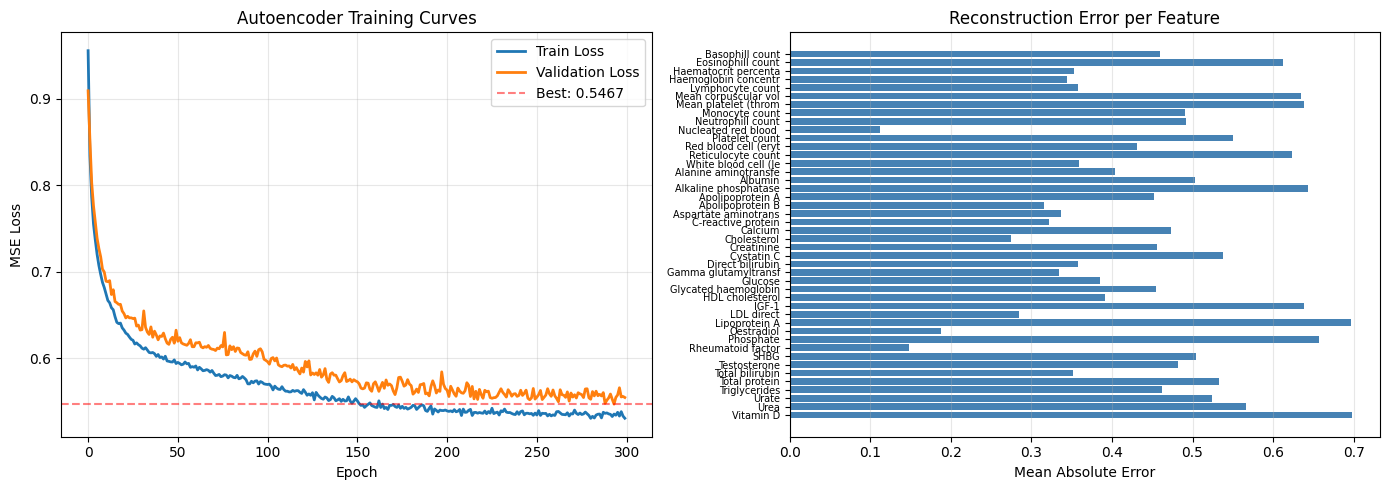


Reconstruction Quality:
  Overall MSE: 0.460696
  Overall MAE: 0.450672
  Worst feature: Vitamin D (MAE=0.6977)


In [29]:
# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss curves
ax1 = axes[0]
ax1.plot(train_losses, label='Train Loss', linewidth=2)
ax1.plot(val_losses, label='Validation Loss', linewidth=2)
ax1.axhline(y=best_val_loss, color='r', linestyle='--', alpha=0.5, label=f'Best: {best_val_loss:.4f}')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('MSE Loss')
ax1.set_title('Autoencoder Training Curves')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Reconstruction quality per feature
ax2 = axes[1]
model.eval()
with torch.no_grad():
    X_tensor = torch.FloatTensor(X_scaled).to(device)
    X_recon, _ = model(X_tensor)
    X_recon = X_recon.cpu().numpy()

recon_error = np.abs(X_scaled - X_recon).mean(axis=0)
feature_names_short = [c.replace(' | Instance 0', '')[:20] for c in feature_cols]
ax2.barh(range(len(recon_error)), recon_error, color='steelblue')
ax2.set_yticks(range(len(recon_error)))
ax2.set_yticklabels(feature_names_short, fontsize=7)
ax2.set_xlabel('Mean Absolute Error')
ax2.set_title('Reconstruction Error per Feature')
ax2.invert_yaxis()
ax2.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print(f"\nReconstruction Quality:")
print(f"  Overall MSE: {((X_scaled - X_recon)**2).mean():.6f}")
print(f"  Overall MAE: {np.abs(X_scaled - X_recon).mean():.6f}")
print(f"  Worst feature: {feature_cols[recon_error.argmax()].replace(' | Instance 0', '')} (MAE={recon_error.max():.4f})")


## Extract Latent Representations and Compute Distance Matrix


In [30]:
# Extract latent representations for ALL patients
model.eval()
with torch.no_grad():
    X_tensor = torch.FloatTensor(X_scaled).to(device)
    _, latent = model(X_tensor)
    latent_repr = latent.cpu().numpy()

n_patients = latent_repr.shape[0]
print(f"Latent representations: {latent_repr.shape}")
print(f"  {n_patients:,} patients × {LATENT_DIM} dimensions")

# Latent space statistics
print(f"\nLatent Space Statistics:")
print(f"  Mean per dim: {latent_repr.mean(axis=0).round(2)}")
print(f"  Std per dim:  {latent_repr.std(axis=0).round(2)}")

# Compute pairwise Euclidean distance in latent space
print(f"\nComputing {n_patients:,}×{n_patients:,} distance matrix...")
distance_matrix = cdist(latent_repr, latent_repr, metric='euclidean')

upper_tri = distance_matrix[np.triu_indices(n_patients, k=1)]
print(f"Distance statistics:")
print(f"  Min: {upper_tri.min():.4f} | Max: {upper_tri.max():.4f}")
print(f"  Mean: {upper_tri.mean():.4f} | Std: {upper_tri.std():.4f}")
print(f"  Memory: {distance_matrix.nbytes / 1e6:.1f} MB")


Latent representations: (10000, 16)
  10,000 patients × 16 dimensions

Latent Space Statistics:
  Mean per dim: [-0.24  0.25 -0.07  0.31  0.14  0.23 -0.38  0.27  0.06 -0.1  -0.13  0.3
 -0.08  0.2  -0.15 -0.08]
  Std per dim:  [0.39 0.29 0.37 0.35 0.42 0.37 0.28 0.42 0.34 0.22 0.31 0.25 0.37 0.46
 0.29 0.34]

Computing 10,000×10,000 distance matrix...
Distance statistics:
  Min: 0.0000 | Max: 18.3444
  Mean: 1.7782 | Std: 0.8492
  Memory: 800.0 MB


In [31]:
distance_matrix

array([[0.        , 2.64250194, 2.40967309, ..., 1.42662277, 1.02137969,
        1.39001778],
       [2.64250194, 0.        , 1.98085558, ..., 1.94302032, 2.22898209,
        2.79134127],
       [2.40967309, 1.98085558, 0.        , ..., 1.34060024, 1.94430162,
        2.21757211],
       ...,
       [1.42662277, 1.94302032, 1.34060024, ..., 0.        , 1.29885172,
        1.3959888 ],
       [1.02137969, 2.22898209, 1.94430162, ..., 1.29885172, 0.        ,
        0.98959937],
       [1.39001778, 2.79134127, 2.21757211, ..., 1.3959888 , 0.98959937,
        0.        ]], shape=(10000, 10000))

In [32]:
# Build KNN graph using sklearn (much faster for large datasets)
from sklearn.neighbors import NearestNeighbors

# Scale K with dataset size (rule of thumb: sqrt(n) or 1-3% of n)
K_NEIGHBORS = max(20, int(np.sqrt(n_patients)))  # At least 20, or sqrt(n)
print(f"Building KNN graph (K={K_NEIGHBORS}, n={n_patients:,})...")

# Use sklearn NearestNeighbors for efficient KNN
nn_model = NearestNeighbors(n_neighbors=K_NEIGHBORS+1, metric='euclidean', n_jobs=-1)
nn_model.fit(latent_repr)
distances_knn, indices_knn = nn_model.kneighbors(latent_repr)

# Build symmetric KNN mask efficiently
knn_mask = np.zeros((n_patients, n_patients), dtype=bool)
for i in range(n_patients):
    neighbors = indices_knn[i, 1:]  # Exclude self
    knn_mask[i, neighbors] = True
    knn_mask[neighbors, i] = True  # Make symmetric

# Normalize KNN distances and convert to similarity
knn_dists = distance_matrix[knn_mask]
min_d, max_d = knn_dists.min(), knn_dists.max()

dist_norm = np.ones_like(distance_matrix)
if max_d > min_d:
    dist_norm[knn_mask] = (distance_matrix[knn_mask] - min_d) / (max_d - min_d)
np.fill_diagonal(dist_norm, 0)

similarity_matrix = 1 - dist_norm
np.fill_diagonal(similarity_matrix, 1)

n_edges = knn_mask.sum() // 2
print(f"\nKNN Graph Statistics:")
print(f"  Edges: {n_edges:,}")
print(f"  Avg degree: {knn_mask.sum(axis=1).mean():.1f}")
print(f"  Sparsity: {100*(1 - knn_mask.sum()/(n_patients**2)):.2f}%")


Building KNN graph (K=100, n=10,000)...

KNN Graph Statistics:
  Edges: 767,448
  Avg degree: 153.5
  Sparsity: 98.47%


In [33]:
similarity_matrix

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], shape=(10000, 10000))

## Louvain Clustering


In [34]:
# Build NetworkX graph efficiently from sparse adjacency
print("Building graph from KNN similarity matrix...")

# Build graph only from KNN edges (much faster than O(n²))
G = nx.Graph()
G.add_nodes_from(range(n_patients))

# Get edge indices from KNN mask
edge_rows, edge_cols = np.where(np.triu(knn_mask, k=1))  # Upper triangle only
edges_with_weights = [
    (int(i), int(j), {'weight': float(similarity_matrix[i, j])})
    for i, j in zip(edge_rows, edge_cols)
    if similarity_matrix[i, j] > 0
]
G.add_edges_from(edges_with_weights)

print(f"Graph built: {G.number_of_nodes():,} nodes, {G.number_of_edges():,} edges")

# Apply Louvain clustering
print("Applying Louvain clustering...")
partition = community_louvain.best_partition(G, weight='weight', random_state=RANDOM_SEED)
cluster_labels = np.array([partition[i] for i in range(n_patients)])

unique_clusters, cluster_counts = np.unique(cluster_labels, return_counts=True)
n_clusters = len(unique_clusters)
modularity = community_louvain.modularity(partition, G, weight='weight')

print(f"\n" + "=" * 50)
print("LOUVAIN CLUSTERING RESULTS")
print("=" * 50)
print(f"Clusters: {n_clusters} | Modularity: {modularity:.4f}")
print(f"\nCluster sizes (top 15):")
for cid, cnt in sorted(zip(unique_clusters, cluster_counts), key=lambda x: -x[1])[:15]:
    print(f"  Cluster {cid}: {cnt:,} ({100*cnt/n_patients:.1f}%)")
if n_clusters > 15:
    print(f"  ... and {n_clusters - 15} more clusters")


Building graph from KNN similarity matrix...
Graph built: 10,000 nodes, 767,395 edges
Applying Louvain clustering...

LOUVAIN CLUSTERING RESULTS
Clusters: 8 | Modularity: 0.5706

Cluster sizes (top 15):
  Cluster 6: 1,623 (16.2%)
  Cluster 0: 1,531 (15.3%)
  Cluster 5: 1,452 (14.5%)
  Cluster 3: 1,437 (14.4%)
  Cluster 1: 1,229 (12.3%)
  Cluster 4: 1,222 (12.2%)
  Cluster 7: 887 (8.9%)
  Cluster 2: 619 (6.2%)


In [35]:
# Clustering quality metric
print("Clustering Quality:")
print("=" * 50)
print(f"Modularity: {modularity:.4f}")


Clustering Quality:
Modularity: 0.5706


## t-SNE and PCA Visualization


In [36]:
# t-SNE on latent space - with optimized parameters for 10k
print("Running t-SNE on latent representations...")
# Perplexity should be < n/3 and typically 5-50; for 10k, use 50
PERPLEXITY = min(50, n_patients // 3)
tsne = TSNE(
    n_components=2, 
    random_state=RANDOM_SEED, 
    perplexity=PERPLEXITY,
    max_iter=1500,  # More iterations for better convergence
    learning_rate='auto',
    init='pca'  # Better initialization
)
X_tsne = tsne.fit_transform(latent_repr)
print(f"t-SNE complete! (perplexity={PERPLEXITY})")


Running t-SNE on latent representations...
t-SNE complete! (perplexity=50)


In [37]:
# PCA on latent representations
from sklearn.decomposition import PCA

print("Running PCA on latent representations...")
pca = PCA(n_components=2, random_state=RANDOM_SEED)
X_pca = pca.fit_transform(latent_repr)

print(f"PCA complete!")
print(f"Explained variance: PC1={pca.explained_variance_ratio_[0]*100:.1f}%, PC2={pca.explained_variance_ratio_[1]*100:.1f}%")
print(f"Total explained: {sum(pca.explained_variance_ratio_)*100:.1f}%")

Running PCA on latent representations...
PCA complete!
Explained variance: PC1=20.7%, PC2=15.5%
Total explained: 36.2%


In [38]:
# Interactive t-SNE visualization with Plotly
# Create DataFrame for plotting
tsne_df = pd.DataFrame({
    't-SNE 1': X_tsne[:, 0],
    't-SNE 2': X_tsne[:, 1],
    'Cluster': cluster_labels.astype(str),
    'Patient ID': patient_ids
})

# Add cluster size info to labels
cluster_sizes = tsne_df['Cluster'].value_counts().to_dict()
tsne_df['Cluster Label'] = tsne_df['Cluster'].apply(lambda x: f'Cluster {x} (n={cluster_sizes[x]})')

# Create interactive scatter plot
fig = px.scatter(
    tsne_df,
    x='t-SNE 1',
    y='t-SNE 2',
    color='Cluster Label',
    hover_data=['Patient ID'],
    title=f'<b>t-SNE of Louvain Clusters (Latent Space)</b><br>'
          f'<sup>{n_patients:,} patients | {n_clusters} clusters | Modularity: {modularity:.4f}</sup>',
    opacity=0.7,
    color_discrete_sequence=px.colors.qualitative.Set1
)

fig.update_traces(marker=dict(size=6))
fig.update_layout(
    width=900,
    height=700,
    legend_title_text='Cluster',
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=1.02
    )
)

fig.show()


In [39]:
# Interactive PCA visualization with Plotly
pca_df = pd.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'Cluster': cluster_labels.astype(str),
    'Patient ID': patient_ids
})

# Add cluster size info to labels
pca_df['Cluster Label'] = pca_df['Cluster'].apply(lambda x: f'Cluster {x} (n={cluster_sizes[x]})')

# Create interactive scatter plot
fig_pca = px.scatter(
    pca_df,
    x='PC1',
    y='PC2',
    color='Cluster Label',
    hover_data=['Patient ID'],
    title=f'<b>PCA of Louvain Clusters (Latent Space)</b><br>'
          f'<sup>{n_patients:,} patients | {n_clusters} clusters | '
          f'Variance explained: {sum(pca.explained_variance_ratio_)*100:.1f}%</sup>',
    opacity=0.7,
    color_discrete_sequence=px.colors.qualitative.Set1
)

fig_pca.update_traces(marker=dict(size=6))
fig_pca.update_layout(
    width=900,
    height=700,
    xaxis_title=f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)',
    yaxis_title=f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)',
    legend_title_text='Cluster',
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=1.02
    )
)

fig_pca.show()

## Feature Importance per Cluster

Analyzing which original features characterize each cluster using mean z-scores deviation from population mean.


In [40]:
# Calculate feature importance per cluster (mean z-scores)
feature_names_clean = [col.replace(' | Instance 0', '') for col in feature_cols]

# Create DataFrame with original scaled features and cluster labels
cluster_profiles = pd.DataFrame(X_scaled, columns=feature_names_clean)
cluster_profiles['Cluster'] = cluster_labels

# Calculate mean z-score per cluster for each feature
cluster_means = cluster_profiles.groupby('Cluster').mean()

# Create interactive heatmap of cluster profiles
fig_heatmap = go.Figure(data=go.Heatmap(
    z=cluster_means.values,
    x=feature_names_clean,
    y=[f'Cluster {i}' for i in cluster_means.index],
    colorscale='RdBu_r',
    zmid=0,
    text=np.round(cluster_means.values, 2),
    texttemplate='%{text}',
    textfont={"size": 8},
    hovertemplate='Cluster: %{y}<br>Feature: %{x}<br>Mean Z-score: %{z:.3f}<extra></extra>'
))

fig_heatmap.update_layout(
    title='<b>Feature Profiles per Cluster</b><br><sup>Mean Z-scores (red=high, blue=low)</sup>',
    xaxis_title='Feature',
    yaxis_title='Cluster',
    width=1200,
    height=500,
    xaxis={'tickangle': 45}
)

fig_heatmap.show()
